# Example 1. Using RU-Net

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/examples/1-example_RUNet.ipynb)

This example demonstrates how to use a pre-trained RU-Net (Regression-U-Net) on experimental images to extrack plankton properties

**NOTE**:
- If you're using google colaboratory to run this notebook, please uncomment the code in the following cell to clone the repository.
- If you're running the notebook on your local machine, please skip this step to avoid cloing the repository in the current folder.

In [1]:
# !git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
# %cd Quantitative-Microplankton-Tracker/examples/

In [2]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup
Import the dependencies to run this tutorial. 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

## 2. Load experimental holographic image
Experimental images are located in ```sample-data``` folder

In [4]:
exp_image = np.load(
    "../data/data_figure2/Oxyrrhis_data.npy"
)[0]

## 3. Load pre-trained RU-Net model
Pre-trained models are located in ```pre-trained models```folder

In [5]:
model = tf.keras.models.load_model(
    "../pre-trained-models/RUNet.h5",
    compile=False
)

## 4. RUNet prediction on experimental image

### 4.1. Normalise the experimental image
Normalise and reshape the image for RU-Net prediction

In [6]:
img = exp_image/np.median(exp_image)
img = img.reshape([1,1024, 1280, 1])
predicted_image = model.predict(img)

### 4.2. Check predictions

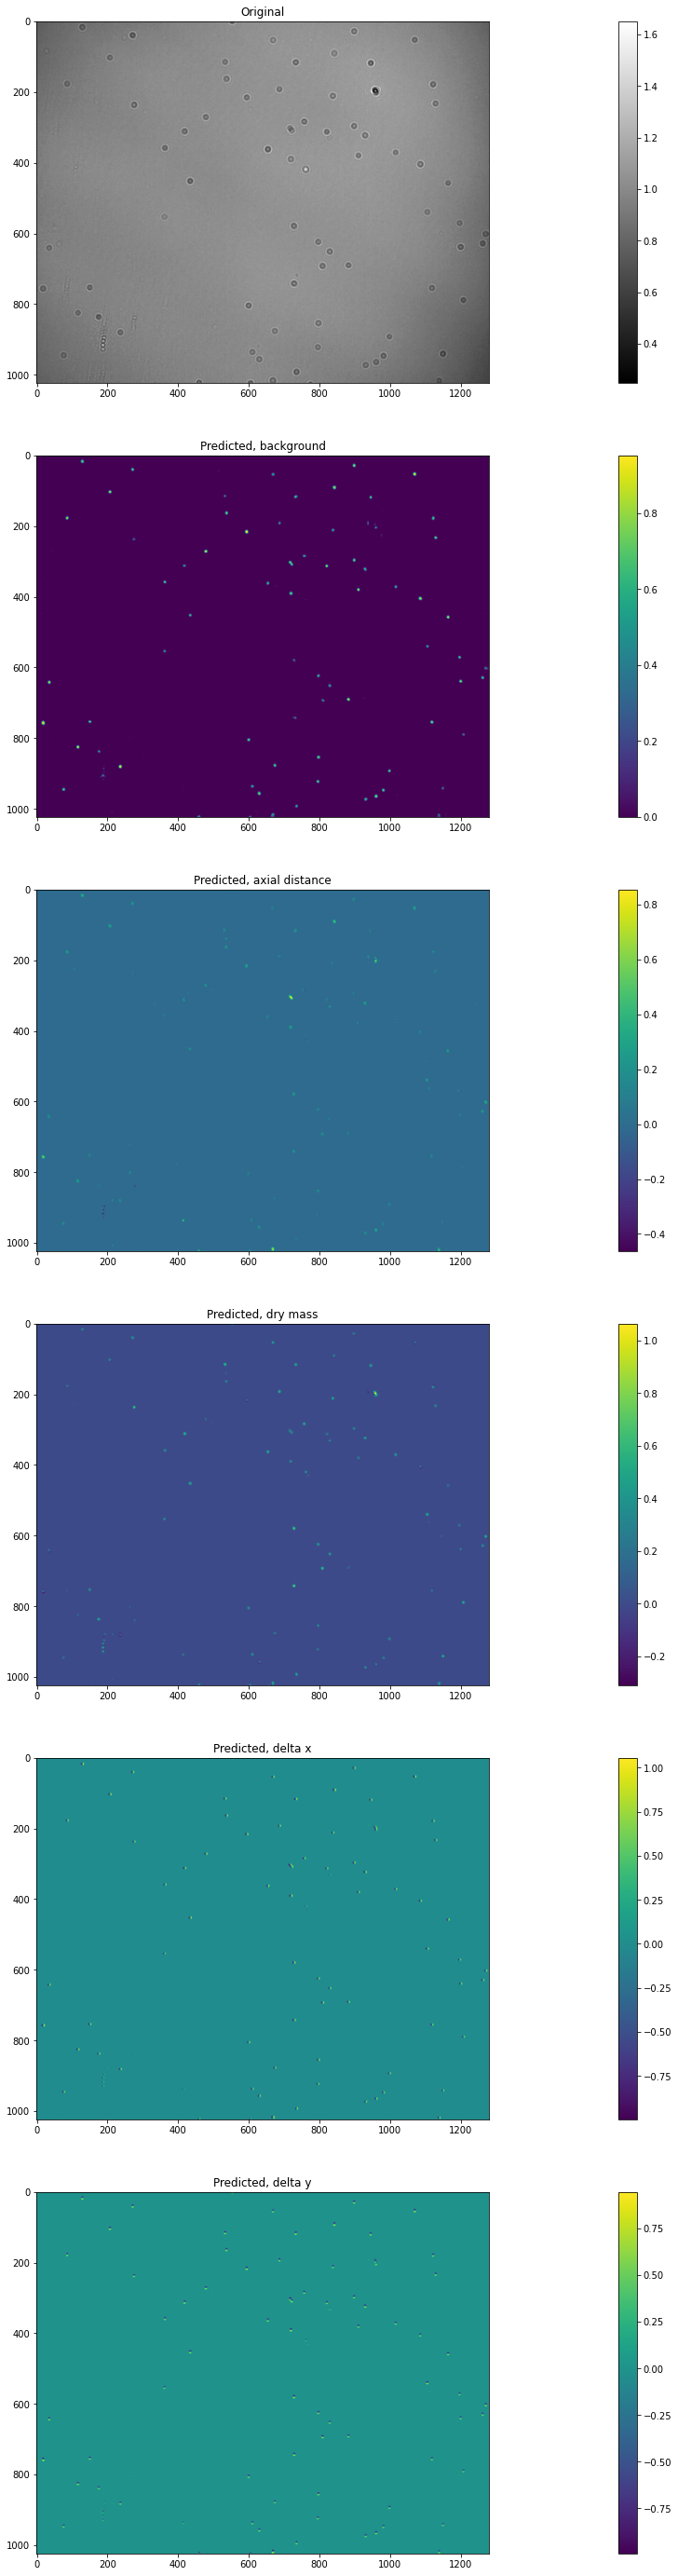

In [7]:
#predictions
fig=plt.figure(figsize=(50,50))

plt.subplot(6,1,1)
plt.imshow((exp_image/np.median(exp_image))  , cmap="gray")
plt.title("Original")
plt.colorbar()

plt.subplot(6,1,2)
plt.imshow(np.squeeze(predicted_image[:, :, :, 0])  ) 
plt.title("Predicted, background")
plt.colorbar()

plt.subplot(6,1,3)
plt.imshow(np.squeeze(predicted_image[:, :, :, 1])  ) 
plt.title("Predicted, axial distance")
plt.colorbar()

plt.subplot(6,1,4)
plt.imshow(np.squeeze(predicted_image[:, :, :, 2])  ) 
plt.title("Predicted, dry mass")
plt.colorbar()

plt.subplot(6,1,5)
plt.imshow(np.squeeze(predicted_image[:, :, :, 3])  ) 
plt.title("Predicted, delta x")
plt.colorbar()

plt.subplot(6,1,6)
plt.imshow(np.squeeze(predicted_image[:, :, :, 4])  ) 
plt.title("Predicted, delta y")
plt.colorbar()

plt.show()


### 4.3. Extrack plankton properties
```predict_image``` function extracts the properties of segmented planktons from RU-Net

In [8]:
def predict_image(predicted_image, threshold):
    """
    Outputs the predicted channels for regression U-nets
    Inputs: image and image threshold, Eg., 0.1
    Outputs: xpositions, ypositions, zpositions, drymass, and eccentricity
    """
    Data = []

    X, Y = np.meshgrid(
        range(0, predicted_image.shape[2]), range(0, predicted_image.shape[1])
    )
    X = np.reshape(X, (predicted_image.shape[1] * predicted_image.shape[2]))
    Y = np.reshape(Y, (predicted_image.shape[1] * predicted_image.shape[2]))

    for i in range(predicted_image.shape[0]):

        zpos = []
        mass = []
        xpos = []
        ypos = []
        ecc = []
        xyri = []

        predX = predicted_image[i, :, :, 3]
        predY = predicted_image[i, :, :, 4]

        gx1, gy1 = np.gradient(predX)
        gx2, gy2 = np.gradient(predY)

        I = gy1 + gx2

        I2 = np.zeros(I.shape)
        I2[I > threshold] = 1

        I3 = label(I2)
        prop = regionprops(I3)

        zs = predicted_image[i, :, :, 1]
        masses = predicted_image[i, :, :, 2]
        I3 = np.reshape(
            I3, (predicted_image.shape[2] * predicted_image.shape[1])
        )
        zs = np.reshape(
            zs, (predicted_image.shape[2] * predicted_image.shape[1])
        )
        masses = np.reshape(
            masses, (predicted_image.shape[2] * predicted_image.shape[1])
        )

        for j in range(np.amax(I3)):
            if prop[j].eccentricity < 1.2:

                ecc.append(prop[j].eccentricity)

                inds = np.where(I3 == j + 1)
                zpos.append(np.mean(zs[inds]))
                mass.append(np.mean(masses[inds]))
                xpos.append(np.mean(X[inds]))
                ypos.append(np.mean(Y[inds]))

                xyri.append(
                    [
                        np.mean(X[inds]),
                        np.mean(Y[inds]),
                        np.mean(zs[inds]),
                        np.mean(masses[inds]),
                    ]
                )

        xyri = np.array(xyri)
        Data.append(xyri)

    return Data

In [9]:
plankton_data_in_image = predict_image(predicted_image, 0.15)[0]

### 4.4. Highlight the planktons

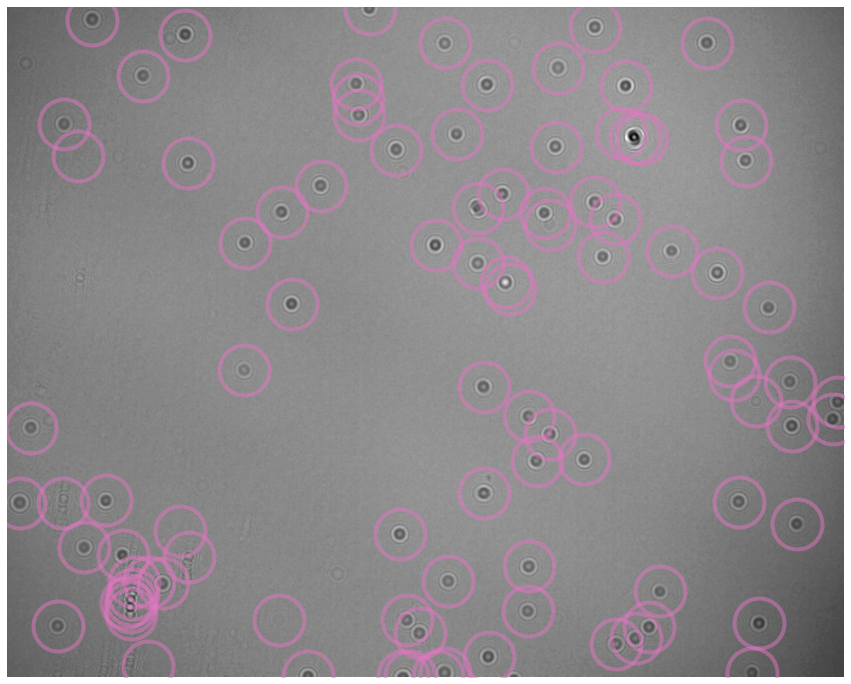

In [10]:
fig, ax = plt.subplots(figsize=(15,15))

ax.imshow(exp_image, cmap='gray')

X = plankton_data_in_image[:, 0]
Y = plankton_data_in_image[:, 1]

for i in range(0,len(X),1):
    x0 = X[i]
    y0 = Y[i]
    ax.plot(x0, y0,'o', ms=50, markerfacecolor="None", markeredgecolor='#e377c2', markeredgewidth=4, alpha=0.5, label='Predator')

plt.axis("off")
plt.show()